In [1]:
import os
import cv2
import platform
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
os.environ['PYTHONHASHSEED'] = '73'

seed = 73
random.seed(seed)
np.random.seed(seed)

print(platform.platform())
%matplotlib inline
#!nvidia-smi
!ls /kaggle/input/

Linux-5.10.123+-x86_64-with-debian-buster-sid
chest-xray-pneumonia  covidx-cxr2


In [2]:
MyDrive = '/kaggle/working'
clear_output()

DataDir = '../input/covidx-cxr2'
PneumoniaDir = '../input/chest-xray-pneumonia/chest_xray'

print('> Covid 19 dir:', os.listdir(DataDir))
print('> Pneumonia dir:', os.listdir(PneumoniaDir))

> Covid 19 dir: ['test.txt', 'train.txt', 'test', 'train']
> Pneumonia dir: ['chest_xray', '__MACOSX', 'val', 'test', 'train']


## **Data Preparation**

In [3]:
from tqdm import tqdm

train_image_dir = PneumoniaDir + '/train'
test_image_dir = PneumoniaDir + '/test'
val_image_dir = PneumoniaDir + '/val'

img_map = []

def prepareData(Dir, strat):
    #cats = ["NORMAL","PNEUMONIA"]
    cats = ["NORMAL"]
    for category in cats:
        path = os.path.join(Dir,category)
        class_num = cats.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path,img)
            img_map.append({'path': img_path, 'label': category})

prepareData(train_image_dir,'train')
prepareData(test_image_dir,'test')
prepareData(val_image_dir, 'val')

100%|██████████| 8/8 [00:00<00:00, 60241.35it/s]


In [4]:
img_map = pd.DataFrame(img_map).sample(frac = 1, random_state=seed)
img_map.tail()

,path,label
323,../input/chest-xray-pneumonia/chest_xray/train...,NORMAL
1416,../input/chest-xray-pneumonia/chest_xray/test/...,NORMAL
394,../input/chest-xray-pneumonia/chest_xray/train...,NORMAL
146,../input/chest-xray-pneumonia/chest_xray/train...,NORMAL
918,../input/chest-xray-pneumonia/chest_xray/train...,NORMAL


### **Getting image path and labels from *.txt files**

In [5]:
#ricord, rsna, cohen, actmed, sirm, 
def getClass(label):
    if label == 'negative':
        return 'NORMAL'
    if label == 'positive':
        return 'COVID'

def get_image_map(txt_path, strat):
    train_txt = open(txt_path, 'r')
    Lines = train_txt.readlines()
    paths = []
    
    img_formats = ['jpg', 'jpeg', 'png']
    
    for n, line in enumerate(Lines):
        querywords = line.split()

        if len(querywords) == 4:
            image_id = querywords[0]
            image_path = DataDir + '/' + strat + '/'+ querywords[1]
            label = querywords[2]

        if len(querywords) == 5:
            image_id = querywords[0]
            image_path = DataDir + '/' + strat + '/'+ querywords[2]
            label = querywords[3]
            
        for img_type in img_formats:
            if img_type in line:
                obj_ = {'path': image_path, 'label': getClass(label)}
                #if (('negative' in line)):
                if (('positive' in line) | ('negative' in line)):
                    paths.append(obj_)

                  

    paths_df = pd.DataFrame(paths)
    return paths_df

In [6]:
train_map = get_image_map(DataDir + '/train.txt', 
                          strat='train').sample(frac = 1, random_state=73)

test_map = get_image_map(DataDir + '/test.txt',
                         strat='test').sample(frac = 1, random_state=73)

In [7]:
img_path_map = pd.concat([img_map, train_map, test_map], axis=0).sample(frac = 1, random_state=73)
img_path_map.head()

,path,label
25280,../input/covidx-cxr2/train/A857849-12-31-1900-...,COVID
24586,../input/covidx-cxr2/train/A576685-12-30-1900-...,COVID
22953,../input/covidx-cxr2/train/A498797-12-31-1900-...,COVID
2539,../input/covidx-cxr2/train/MIDRC-RICORD-1C-SIT...,COVID
3770,../input/covidx-cxr2/train/46589ee8-5fe8-4b85-...,NORMAL


### **Visualization**

In [8]:
def getLabelCount(frame):
    label_count = pd.Series(frame['label'].values.ravel()).value_counts()
    n_classes = (label_count)
    return label_count

label_count = getLabelCount(img_path_map)
print(label_count)
df_main=img_path_map
df_main

COVID     16194
NORMAL    15773
dtype: int64


,path,label
25280,../input/covidx-cxr2/train/A857849-12-31-1900-...,COVID
24586,../input/covidx-cxr2/train/A576685-12-30-1900-...,COVID
22953,../input/covidx-cxr2/train/A498797-12-31-1900-...,COVID
2539,../input/covidx-cxr2/train/MIDRC-RICORD-1C-SIT...,COVID
3770,../input/covidx-cxr2/train/46589ee8-5fe8-4b85-...,NORMAL
...,...,...
10135,../input/covidx-cxr2/train/fd7047e2-1865-4f07-...,NORMAL
13922,../input/covidx-cxr2/train/b05deb36-6273-45fb-...,NORMAL
664,../input/covidx-cxr2/train/f46a9bfc7222e61e099...,COVID
27928,../input/covidx-cxr2/train/A292777-01-15-1901-...,COVID


In [9]:
normal  = df_main[df_main['label']=='NORMAL'] 
pneumonia  = df_main[df_main['label']=='COVID'] 
normal.head()
pneumonia.head()


,path,label
25280,../input/covidx-cxr2/train/A857849-12-31-1900-...,COVID
24586,../input/covidx-cxr2/train/A576685-12-30-1900-...,COVID
22953,../input/covidx-cxr2/train/A498797-12-31-1900-...,COVID
2539,../input/covidx-cxr2/train/MIDRC-RICORD-1C-SIT...,COVID
21670,../input/covidx-cxr2/train/A558243-01-04-1901-...,COVID


In [10]:
pneumonia.drop(pneumonia.tail(11462).index, inplace=True)
def getLabelCount(frame):
    label_count = pd.Series(frame['label'].values.ravel()).value_counts()
    n_classes = (label_count)
    return label_count

label_count = getLabelCount(pneumonia)
print(label_count)

COVID    4732
dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
from sklearn.model_selection import train_test_split
#train_data, test_data= train_test_split(df_main, train_size=0.85, random_state=0,shuffle=True)
test_data= test_map
train_normal, valid_normal = train_test_split(normal, train_size=0.7, random_state=0,shuffle=True)
print(len(test_data))
print(len(valid_normal))

400
4732


In [12]:
batch_size=64
# train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
#                                    shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
# train_datagen = ImageDataGenerator(
#     rescale = 1./255.,
#     rotation_range = 30, # Randomly rotating pictures, it takes values between 0-180
#     shear_range = 0.2, # Shear Intensity
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range = 0.2, # Randomly zooming pictures
#     horizontal_flip = True # Randomly flipping half of the images horizontally
# )
train_datagen = ImageDataGenerator(rescale = 1.0/255.)
valid_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

#Now fit the them to get the images from directory (name of the images are given in dataframe) with augmentation


train_generator = train_datagen.flow_from_dataframe(dataframe = train_normal, x_col='path', 
                                              y_col='label', target_size=(128,128), batch_size=batch_size, 
                                               class_mode='input')
valid_generator = valid_datagen.flow_from_dataframe(dataframe = valid_normal, x_col='path', 
                                              y_col='label', target_size=(128,128), batch_size=batch_size, 
                                            class_mode='input')
anomaly_generator = test_datagen.flow_from_dataframe(dataframe = pneumonia, x_col='path', 
                                              y_col='label', target_size=(128,128), batch_size=batch_size,
                                             class_mode='input')
                                   
test_generator = test_datagen.flow_from_dataframe(dataframe = test_data, x_col='path', 
                                              y_col='label', target_size=(128,128), batch_size=batch_size,
                                             class_mode="binary")
validation_generator=valid_generator

Found 11041 validated image filenames.
Found 4732 validated image filenames.
Found 4732 validated image filenames.
Found 400 validated image filenames belonging to 2 classes.


In [13]:
from keras.metrics import Accuracy, Precision, Recall, AUC
SIZE= 128
#Encoder
model = Sequential()
model.add(Conv2D(8, (3, 3), padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Flatten())
#model.add(Dense(256))
model.add(Dense(128))

#model.add(Dense(256))
model.add(Dense(8192))
model.add(LeakyReLU(alpha=0.2))
model.add(Reshape((16,16,32)))

model.add(Conv2DTranspose(32, (3, 3),  padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(UpSampling2D((2, 2)))

model.add(Conv2DTranspose(16, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(UpSampling2D((2, 2)))

model.add(Conv2DTranspose(8, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics='mse')
#model.summary()


In [14]:
history = model.fit(
        train_generator,
        steps_per_epoch= len(train_normal) // batch_size,
        epochs=50,
        validation_data=valid_generator,
        validation_steps=len(valid_normal) // batch_size
)

Epoch 1/50
172/172 [==============================] - 638s 4s/step - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 2/50
172/172 [==============================] - 291s 2s/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0247 - val_mse: 0.0247
Epoch 3/50
172/172 [==============================] - 292s 2s/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 4/50
172/172 [==============================] - 291s 2s/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 5/50
172/172 [==============================] - 290s 2s/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 6/50
172/172 [==============================] - 287s 2s/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 7/50
172/172 [==============================] - 288s 2s/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 8/50
172/172 [==============================] - 289s 2s/step - 

In [15]:
model.save_weights("AE_weightsepochs.h5")
model.save('AE.h5')

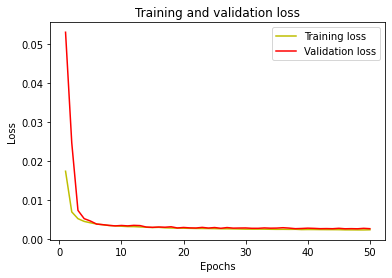

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
validation_error = model.evaluate(valid_generator)
anomaly_error = model.evaluate(anomaly_generator)
recon_th=validation_error[0]
print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)
print(recon_th)

74/74 [==============================] - 164s 2s/step - loss: 0.0060 - mse: 0.0060
Recon. error for the validation (normal) data is:  [0.0025798797141760588, 0.0025798797141760588]
Recon. error for the anomaly data is:  [0.005978716071695089, 0.005978716071695089]
0.0025798797141760588


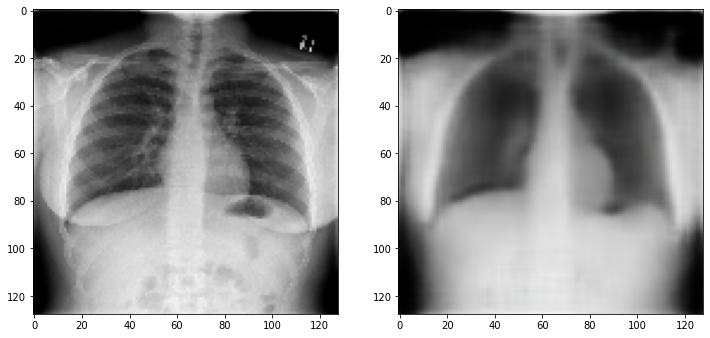

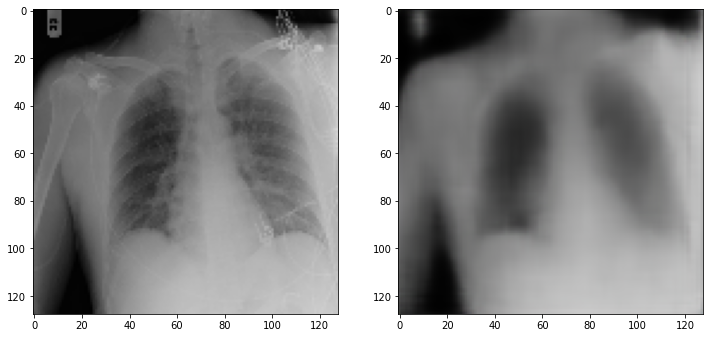

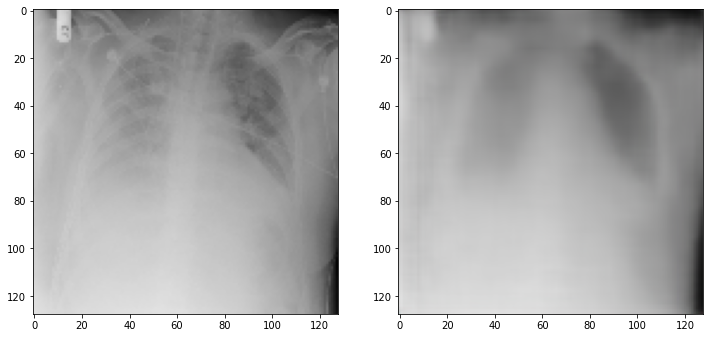

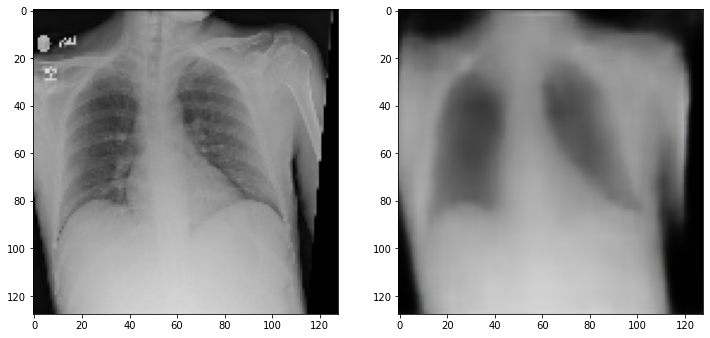

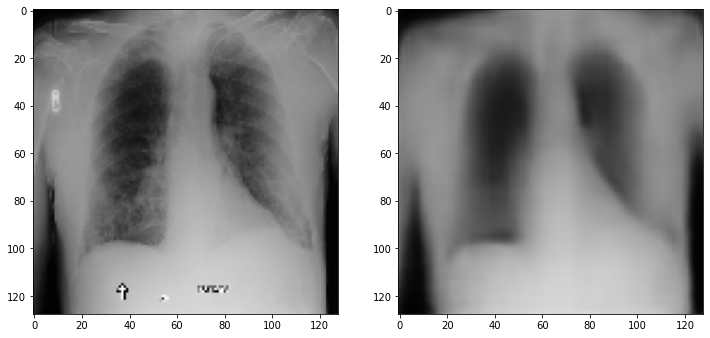

In [18]:
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1
predicted = model.predict(data_batch[0])  #Predict on the first batch of images
#image_number = random.randint(0, predicted.shape[0])
for image_number in range(0,5):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(data_batch[0][image_number])
    plt.subplot(122)
    plt.imshow(predicted[image_number])
    plt.show()

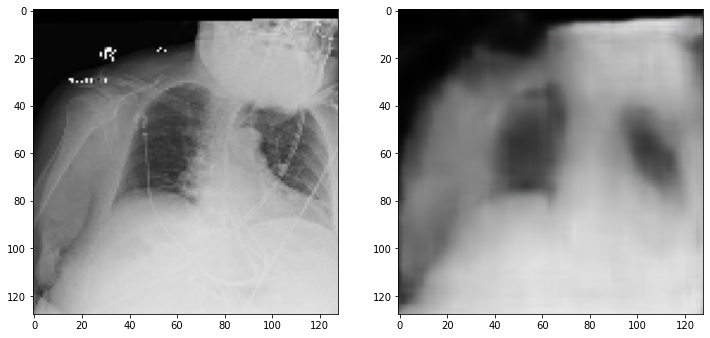

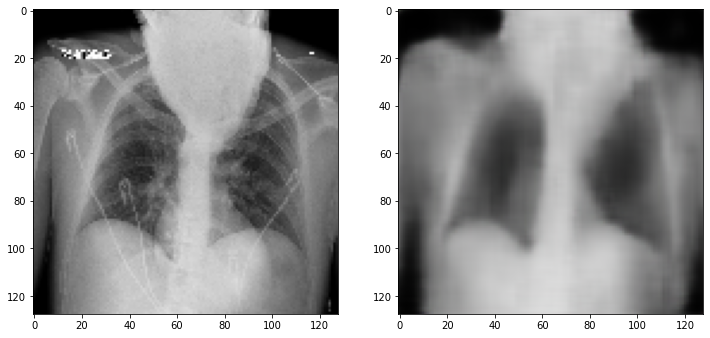

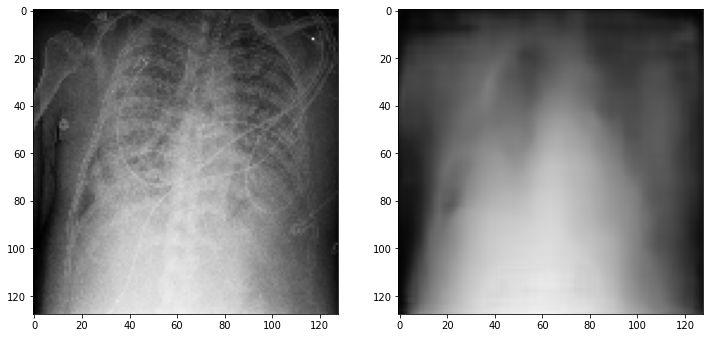

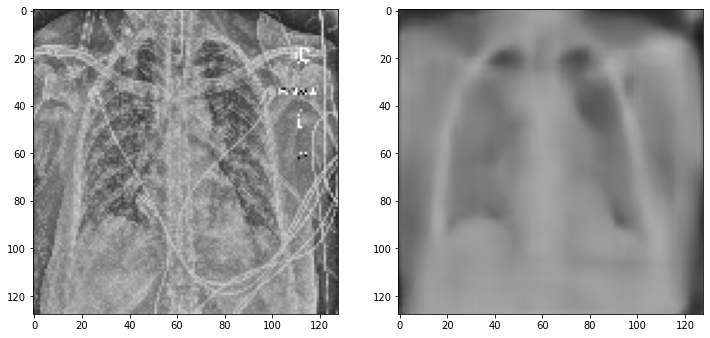

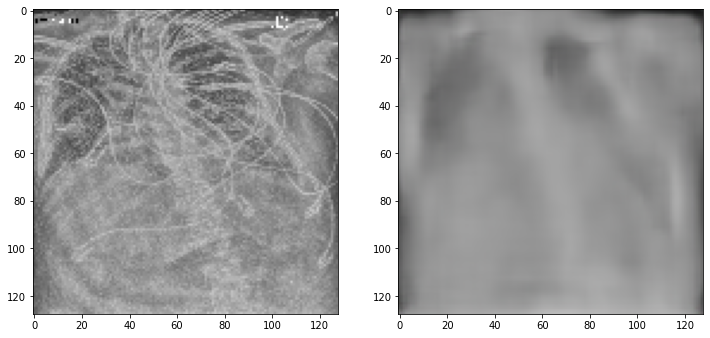

In [19]:
data_batch1 = []  #Capture all training batches as a numpy array
img_num1 = 0
while img_num1 <= anomaly_generator.batch_index:   #gets each generated batch of size batch_size
    data1 = anomaly_generator.next()
    data_batch1.append(data1[0])
    img_num1 = img_num1 + 1
predicted1 = model.predict(data_batch1[0])
#image_number1 = random.randint(0, predicted1.shape[0])
for image_number1 in range(0,5):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(data_batch1[0][image_number1])
    plt.subplot(122)
    plt.imshow(predicted1[image_number1])
    plt.show()

In [20]:
x=np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
y=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])
print(x.shape)
print(y.shape)
y=y.astype(bool)

(400, 128, 128, 3)
(400,)


In [21]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def calc_density_and_recon_error(data=x): 
    density_list=[]
    recon_error_list=[]
    preds_list=[]
    for im in (data):
        img=im
        img = img[np.newaxis, :,:,:]
#         encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
#         encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        #density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        #density_list.append(density)
        
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        #preds=tf.math.greater(reconstruction_error, recon_th) or tf.math.less(density, dens_th)
        preds=tf.math.less(reconstruction_error, recon_th) 
        recon_error_list.append(reconstruction_error)
        preds_list.append(preds)
        #print(preds_list)
        
#     average_density = np.mean(np.array(density_list))  
#     stdev_density = np.std(np.array(density_list)) 
    
        average_recon_error = np.mean(np.array(recon_error_list))  
#     stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    test_accuracy=accuracy_score(y, preds_list)
    test_recall=recall_score(y, preds_list)
    test_precision=precision_score(y, preds_list)
    test_roc_auc=roc_auc_score(y, preds_list)
    return average_recon_error, test_accuracy, test_recall, test_precision, test_roc_auc
    #return average_recon_error, test_accuracy, test_recall, test_precision, test_roc_auc, stdev_recon_error, average_density, stdev_density 


In [22]:
test_values = calc_density_and_recon_error()
test_values

1/1 [==============================] - 0s 22ms/step - loss: 0.0022 - mse: 0.0022


(0.003299970840162132, 0.51, 0.365, 0.5140845070422535, 0.51)